In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json
import os
import pickle

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
root = os.getcwd()
data_root = os.path.join(root, 'data')

In [4]:
from CleanText import *

[nltk_data] Downloading package punkt to /Users/nhungle/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Clean Texts

In [5]:
covid19_df = pickle.load(open(os.path.join(data_root, 'covid19_literatur.pickle'), "rb"))

In [8]:
covid19_df.columns

Index(['paper_id', 'abstract', 'body_text', 'authors', 'title', 'journal',
       'abstract_summary'],
      dtype='object')

In [9]:
covid19_df['abstract'] = clean_text(covid19_df['abstract'])

In [12]:
# covid19_df['abstract_summary'] = clean_text(covid19_df['abstract_summary'])
# covid19_df['body_text'] = clean_text(covid19_df['body_text'])

# Train Test Split

In [32]:
from sklearn.model_selection import train_test_split
abstracts = covid19_df['abstract']
# test set size of 20% of the data and the random seed 42 <3
abstract_train, abstract_test = train_test_split(abstracts,
                                                 test_size=0.2,
                                                 random_state=42)

print("abstract size:", len(abstract_train))
print("abstract_test size:", len(abstract_test))

abstract size: 22142
abstract_test size: 5536


In [27]:
#list(abstract_train)

# Vectorize Texts

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
abstract_train_transformed = tfidf_vectorizer.fit_transform(list(abstract_train))
abstract_test_transformed = tfidf_vectorizer.transform(abstract_test)

In [35]:
len(tfidf_vectorizer.vocabulary_)

115938

# Clustering Models

### KMeans

1. Fit a KMeans model

In [39]:
k = 2
km = KMeans(n_clusters=k, max_iter=100)
km.fit(abstract_train_transformed)

In [41]:
km.cluster_centers_.argsort()

array([[115937,  66831,  66830, ...,  18147,  63633,  35854],
       [ 78418,  77688,  77689, ...,  18147,  78309, 105189]])

In [55]:
km.inertia_

14903.00131171055

In [42]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()

In [54]:
for i in range(k):
    print("Cluster {}".format(i))
    # get top 10 words for each cluster
    for ind in order_centroids[i, :10]:
        print(terms[ind])

Cluster 0
de
la
and
of
en
the
des
les
et
in
Cluster 1
the
of
and
in
to
for
with
that
were
is


2. Find best k using elbow

In [59]:
sum_of_squared_distance = []
for k in range(2, 20):
    km = KMeans(n_clusters=k, max_iter=100)
    km.fit(abstract_train_transformed)
    sum_of_squared_distance.append(km.inertia_)
    

Text(0, 0.5, 'Sum of squared distance')

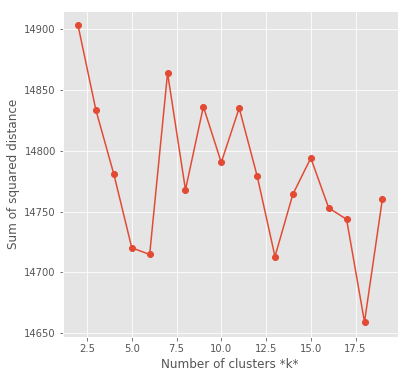

In [60]:
plt.figure(figsize=(6, 6))
plt.plot([i for i in range(2, 20)], sum_of_squared_distance, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')